In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import sys; sys.path.append("../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
data_dir = root_dir / "Data"

model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

log_dir = root_dir / "Logs"
log_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
# This dataset is used for object detection and segmentation, but here we will adapt it
# for image classification only.
config = maskflow.config.load_config(root_dir / "config.yaml")

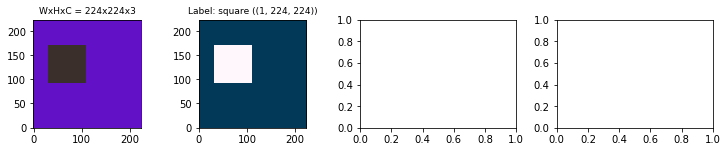

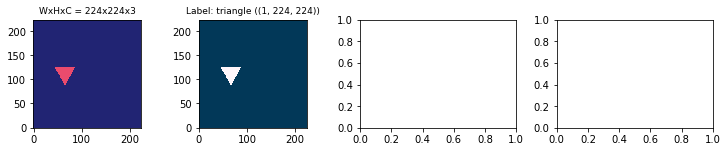

In [2]:
# Load training and test dataset
class_names = config["DATASET"]["CLASS_NAMES"]

train_file_path = data_dir / "train.tfrecords"
test_file_path = data_dir / "test.tfrecords"

train_raw_dataset = maskflow.dataset.parse(train_file_path, config, repeat_count=1,
                                           shuffle=True, do_preprocess=True)

test_raw_dataset = maskflow.dataset.parse(test_file_path, config, repeat_count=1,
                                          shuffle=False, do_preprocess=True)

# Display
dataset_to_display = train_raw_dataset.take(2)
maskflow.viz.batch_display_top_masks(dataset_to_display, class_names, basesize=10, limit=3, cmap="PuBu_r")

In [3]:
# Preprocess the dataset
train_dataset = train_raw_dataset
test_dataset = test_raw_dataset

# Normalize the images.
def _normalize_image_intensities(pixel_mean, pixel_std):
    def _fn(datum):
        image = tf.cast(datum['image'], dtype="float32")
        image -= pixel_mean
        image /= pixel_std
        datum['image'] = image
        return datum
    return _fn

pixel_mean = config["DATASET"]['PIXEL_MEAN']
pixel_std = config["DATASET"]['PIXEL_STD']

normalize_fn = _normalize_image_intensities(pixel_mean, pixel_std)
train_dataset = train_dataset.map(normalize_fn)
test_dataset = test_dataset.map(normalize_fn)

def _prepare_classification(datum):
    """Prepare a Maskflow dataset for classification."""
    image = datum['image']
    label = datum['label_ids'][0]
    return image, label

train_dataset = train_dataset.map(_prepare_classification)
test_dataset = test_dataset.map(_prepare_classification)

image, label = [datum for datum in train_dataset.take(1)][0]

In [ ]:
# Build the model
num_classes = len(class_names)

image_size = config["DATASET"]['IMAGE_SIZE']
n_channels = config["DATASET"]['N_CHANNELS']
input_shape = (None, image_size, image_size, n_channels)

tf.keras.backend.clear_session()
model_name = "efficientnet-b1"
model = maskflow.model.build_efficientnet(model_name, num_classes=len(class_names), log=False)
model.build(input_shape=input_shape)

# fake_input = np.zeros([1] + list(input_shape[1:]), dtype='float32')
# _ = model(fake_input, training=True, features_only=True)

model.summary()

In [ ]:
# Run training
batch_size = 16
n_epochs = 100

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=0.9, epsilon=0.001, momentum=0.9)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

def lr_scheduler(epoch):
    "Exponential decay."
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k * epoch)
    return lrate

# Callbacks
log_path = log_dir / datetime.datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
tb = tf.keras.callbacks.TensorBoard(log_dir=str(log_path), write_images=False, write_graph=True)
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
#chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoints_path), monitor="accuracy", save_best_only=True, verbose=1)
callbacks = [tb]#, scheduler]#, chkpt]

train_dataset_fit = train_dataset.batch(batch_size)
train_dataset_fit = train_dataset_fit.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset_fit = test_dataset.batch(batch_size)
test_dataset_fit = test_dataset_fit.prefetch(tf.data.experimental.AUTOTUNE)

model.fit(train_dataset_fit, validation_data=test_dataset_fit, epochs=n_epochs,
          callbacks=callbacks, verbose=1)

In [ ]:
# Export to Saved Model
model_path = model_dir / "Classification" / "efficientnet"
model_path.mkdir(exist_ok=True, parents=True)

@tf.function(input_signature=[tf.TensorSpec(input_shape, dtype=tf.float32)])
def model_predict(input_batch):
    return {'outputs': model(input_batch, training=False)}

tf.saved_model.save(model, str(model_path), signatures={'predict': model_predict})

In [ ]:
# Load model
loaded = tf.saved_model.load(str(model_path))
infer = loaded.signatures["predict"]

In [ ]:
image, label = [datum for datum in test_dataset.shuffle(1000).take(2)][-1]
image = tf.expand_dims(image, 0)
label = tf.expand_dims(label, 0)

label.numpy(), class_names, plt.imshow(image[0])

In [ ]:
model.predict(image)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  accuracy = tf.metrics.SparseCategoricalAccuracy()(y_true, y_pred)
  return accuracy

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 20

model.fit(dataset, epochs=EPOCHS)